In [1]:
import pandas as pd
import numpy as np
import itertools
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.factorplots import interaction_plot
from sklearn.linear_model import LinearRegression

# 通気層の放射熱伝達率の推定方法の検証
## 分析用データの読み込み

In [2]:
# CSVファイルを読み込む
df = pd.read_csv('wall_status_data_frame.csv', index_col=0)

# 温度差の列を追加
df["delta_theta_as_e-theta_r"] = df["theta_as_e"] - df["theta_r"]
df["delta_theta_sat-theta_r"] = df["theta_sat"] - df["theta_r"]


# 収束しなかった場合のデータを削除する
df = df.query("is_optimize_succeed == True")

# 分析用にメッセージ列を削除
df = df.drop(["is_optimize_succeed", "optimize_message"], axis=1)

# 1つでも欠損値NaNがある行を削除する
df = df[~np.isnan(df).any(axis=1)]

## 冬期条件、夏期条件の計算結果をそれぞれ抽出

In [3]:
# 冬期条件の計算結果を抽出
df_winter = df.query("theta_e <= 10.0 & theta_r == 20.0")
df_winter

,theta_e,theta_r,j_surf,a_surf,C_1,C_2,l_h,l_w,l_d,angle,...,theta_as_e,k_e,q_room_side,heat_balance_0,heat_balance_1,heat_balance_2,heat_balance_3,heat_balance_4,delta_theta_as_e-theta_r,delta_theta_sat-theta_r
0,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-4.538192,0.817940,-2.315751,2.842171e-14,2.886580e-15,-1.776357e-15,-2.842171e-14,-2.220446e-16,-24.538192,-30.0
1,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-4.941901,0.831397,-2.401513,0.000000e+00,7.105427e-15,-7.105427e-15,5.684342e-14,-8.881784e-16,-24.941901,-30.0
2,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-4.989114,0.832970,-2.426156,2.842171e-14,0.000000e+00,-3.552714e-15,2.842171e-14,4.440892e-16,-24.989114,-30.0
3,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-9.856252,0.995208,-2.898810,2.842171e-14,8.881784e-15,0.000000e+00,0.000000e+00,0.000000e+00,-29.856252,-30.0
4,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-9.814749,0.993825,-2.907471,-2.842171e-14,-3.552714e-15,-7.105427e-15,0.000000e+00,-8.881784e-16,-29.814749,-30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295240,10.0,20.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,24.918480,0.163949,11.581242,-4.547474e-13,-3.979039e-13,-1.136868e-13,0.000000e+00,-1.776357e-15,4.918480,30.0
295241,10.0,20.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,28.197296,0.273243,20.333083,4.547474e-13,0.000000e+00,1.136868e-13,-5.684342e-14,8.881784e-16,8.197296,30.0
295242,10.0,20.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,15.758518,-0.141383,-9.968510,-4.547474e-13,1.527667e-12,8.526513e-14,2.842171e-14,-1.776357e-15,-4.241482,30.0
295243,10.0,20.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,20.797442,0.026581,1.976428,4.547474e-13,-3.410605e-13,-5.684342e-14,0.000000e+00,8.881784e-16,0.797442,30.0


In [4]:
# 夏期条件の計算結果を抽出
df_summer = df.query("theta_e >= 25.0 & theta_r == 27.0")
df_summer

,theta_e,theta_r,j_surf,a_surf,C_1,C_2,l_h,l_w,l_d,angle,...,theta_as_e,k_e,q_room_side,heat_balance_0,heat_balance_1,heat_balance_2,heat_balance_3,heat_balance_4,delta_theta_as_e-theta_r,delta_theta_sat-theta_r
413343,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,25.350496,0.824752,-0.151263,0.000000e+00,-1.261213e-13,-1.456613e-13,0.000000e+00,0.000000e+00,-1.649504,-2.0
413344,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,25.331103,0.834448,-0.160687,-1.136868e-13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.668897,-2.0
413345,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,25.332025,0.833987,-0.162361,0.000000e+00,-1.421085e-14,2.842171e-14,0.000000e+00,0.000000e+00,-1.667975,-2.0
413346,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,25.011235,0.994383,-0.191872,0.000000e+00,1.421085e-14,0.000000e+00,-2.842171e-14,0.000000e+00,-1.988765,-2.0
413347,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,25.018480,0.990760,-0.193134,0.000000e+00,1.421085e-14,0.000000e+00,-2.842171e-14,3.552714e-15,-1.981520,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708583,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,50.470072,0.488960,56.476449,0.000000e+00,-4.547474e-13,-1.136868e-13,8.526513e-14,0.000000e+00,23.470072,48.0
708584,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,53.646967,0.555145,67.754820,-1.818989e-12,-2.842171e-13,-2.273737e-13,2.842171e-14,0.000000e+00,26.646967,48.0
708585,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,40.829960,0.288124,32.700991,-9.094947e-13,4.227729e-13,5.684342e-14,-2.842171e-14,-3.552714e-15,13.829960,48.0
708586,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,46.506060,0.406376,49.057263,-9.094947e-13,1.023182e-12,2.273737e-13,-8.526513e-14,7.105427e-15,19.506060,48.0


## 作図用の関数を定義
### 散布図（線形回帰式あり）を作図する関数

In [5]:
def setPltSingle(df:pd.DataFrame, fig_title:str, x_label:str, y_label:str, x_data_name:str, y_data_name:str):
    
    """
    グラフを描画する（2変数の散布図、線形回帰式あり）
    
    :param df: CSVファイルの全データ
    :param fig_title: グラフタイトル
    :param x_label: X軸のラベル
    :param y_label: Y軸のラベル
    :param x_data_name: X軸に設定するデータの名称
    :param y_data_name: Y軸に設定するデータの名称
    :return: なし
    """
        
    # グラフを表示する領域（figureオブジェクト）、グラフを描画する領域（Axesオブジェクト）を作成
    fig, ax = plt.subplots()

    # グラフタイトルを設定
    fig.suptitle(fig_title)
    
    # 単回帰分析を行うsklearn.linear_model.LinearRegressionクラスを読み込み
    model_lr = LinearRegression()

    # 補助軸の設定
    ax.grid(which='major', color='gray', linestyle='-')
    ax.grid(which='minor', color='gray', linestyle='-')
    
    # 軸ラベルの設定
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    # 描画データ設定
    x = df[x_data_name].to_numpy().reshape(-1, 1)
    y = df[y_data_name].to_numpy().reshape(-1, 1)

    # 線形回帰モデルを作成
    model_lr.fit(x, y)
    a = model_lr.coef_[0][0]   # 回帰係数
    b = model_lr.intercept_[0] # 切片 (誤差)
    r2 = model_lr.score(x, y)  # 決定係数
    
    # 散布図の描画設定
    ax.scatter(x, y, s=30, marker=".")
        
    # 線形近似の描画設定
    ax.plot(x, model_lr.predict(x),color="black")

    # 近似式の表示（text関数の引数：x座標、y座標、表示するテキスト）
    ax.text(np.mean(x), np.mean(y) + np.mean(y) * 0.1, 'y='+ str(round(a, 3)) +'x+'+str(round(b,3)))
    #ax.text(np.median(x) + np.median(x) * 0.1, np.median(y), 'y='+ str(round(a, 3)) +'x+'+str(round(b,3)))
        
    # 決定係数の表示
    ax.text(np.mean(x), np.mean(y) + np.mean(y) * 0.4, 'R2='+ str(round(r2,4)))
    #ax.text(np.median(x) + np.median(x) * 0.1, np.median(y)-1, 'R2='+ str(round(r2,4)))

    # グラフ描画
    plt.show()

### 推定値の確認用グラフを作図する関数

In [6]:
def setPltComparison(df:pd.DataFrame, fig_title:str, x_label:str, y_label:str, x_data_name:str, y_data:np.array):
    
    # グラフを表示する領域（figureオブジェクト）、グラフを描画する領域（Axesオブジェクト）を作成
    fig, ax = plt.subplots()

    # グラフタイトルを設定
    fig.suptitle('Comparison Result of h_cv')
        
    # 補助軸の設定
    ax.grid(which='major', color='gray', linestyle='-')
    ax.grid(which='minor', color='gray', linestyle='-')
        
    # 軸ラベルの設定
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
        
    # 描画データ設定
    x = df[x_data_name].to_numpy().reshape(-1, 1)
    y = y_data
                
    # 散布図の描画設定
    ax.scatter(x, y, s=30, marker=".")

    # 線形グラフの描画設定    
    ax.plot([-5.0, 15.0], [-5.0, 15.0],color="black")
        
    # 軸の描画範囲設定
    ax.set_xlim(-5.0, 15.0)
    ax.set_ylim(-5.0, 15.0)
    
    # グラフ描画
    plt.show()

### 1行×3列の散布図（線形回帰式あり）を作図する関数

In [7]:
def setPltThreeCols(df:pd.DataFrame, fig_title:str, x_label:str, y_label:str, x_data_name:str, y_data_name:str,
           condition_data_name:str, unit_label:str, conditions:np.array):
    
    """
    グラフ描画設定を行い、グラフを描画する（1行×3列の3つのグラフを描画）
    :param df: CSVファイルの全データ
    :param fig_title: グラフタイトル
    :param x_label: X軸のラベル
    :param y_label: Y軸のラベル
    :param x_data_name: X軸に設定するデータの名称
    :param y_data_name: Y軸に設定するデータの名称
    :param condition_data_name: 抽出条件を設定するデータの名称
    :param unit_label: 抽出条件を設定するデータの単位
    :param conditions: 抽出条件
    :return: なし
    """
        
    # グラフを表示する領域（figureオブジェクト）、グラフを描画する領域（Axesオブジェクト）を作成
    fig, axs = plt.subplots(1,3,figsize=(11.5,3.5))

    # グラフタイトルを設定
    fig.suptitle(fig_title)
    
    # グラフプロットの色を設定
    colors = np.array(["r", "g", "b"])
    
    # 単回帰分析を行うsklearn.linear_model.LinearRegressionクラスを読み込み
    model_lr = LinearRegression()

    # 個別のグラフ描画設定を行う
    for i, ax in enumerate(axs):
        
        # 補助軸の設定
        ax.grid(which='major', color='gray', linestyle='-')
        ax.grid(which='minor', color='gray', linestyle='-')
        
        # 軸ラベルの設定
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        
        # 描画データ設定
        condition = condition_data_name + " == " + str(conditions[i])
        axes_title = condition_data_name + ": " + str(conditions[i]) + "[" + unit_label + "]"
        x = df.query(condition)[x_data_name].to_numpy().reshape(-1, 1)
        y = df.query(condition)[y_data_name].to_numpy().reshape(-1, 1)
        
        # 線形回帰モデルを作成
        model_lr.fit(x, y)
        a = model_lr.coef_[0][0]          # 回帰係数
        b = model_lr.intercept_[0]     # 切片 (誤差)
        r2 = model_lr.score(x, y)  # 決定係数
        
        # 散布図の描画設定
        ax.scatter(x, y,color=colors[i], label=axes_title, s=30, marker=".")
    
        # 線形近似の描画設定
        ax.plot(x, model_lr.predict(x),color="black")
        
        # 近似式の表示（text関数の引数：x座標、y座標、表示するテキスト）
        ax.text(np.mean(x), np.mean(y) + np.mean(y) * 0.1, 'y='+ str(round(a, 3)) +'x+'+str(round(b,3)))
        
        # 決定係数の表示
        ax.text(np.mean(x), np.mean(y) + np.mean(y) * 0.4, 'R2='+ str(round(r2,4)))
        
        # 軸の描画範囲設定
        ax.set_xlim(0, 8)
        #ax.set_ylim(-25.0, 85.0)
        
        # 個別グラフのタイトル設定
        ax.set_title(axes_title)
        
        # 凡例の表示
        ax.legend() 
    
    # レイアウト設定
    fig.tight_layout(rect=[0,0,1,0.96])

    # グラフ描画
    plt.show()

## 放射熱伝達率の検証
### 重回帰分析：冬期条件

In [8]:
# 最小二乗法による回帰モデルを作成
formula_1 = "h_rv ~ theta_e + j_surf + a_surf + C_1 + C_2 + l_h + l_w + l_d + angle + v_a + emissivity_2"
model_winter = ols(formula_1, df_winter).fit()
model_winter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   h_rv   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                 5.361e+05
Date:                Sun, 27 Dec 2020   Prob (F-statistic):               0.00
Time:                        18:16:39   Log-Likelihood:                -2473.2
No. Observations:              157464   AIC:                             4970.
Df Residuals:                  157452   BIC:                             5090.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.1209      0.003    -42.864      0.000      -0.126      -0.115
theta_e          0.0204   7.37e-05    276.939      0.000       0.020       0.021
j_surf           0.0002   1.47e-06    169.197      0.000       0.000       0.000
a_surf           0.2494      0.001    169.197      0.000       0.246       0.252
C_1              0.0002   1.52e-05     12.572      0.000       0.000       0.000
C_2              0.0187      0.000     60.279      0.000       0.018       0.019
l_h              0.0021      0.000     12.543      0.000       0.002       0.002
l_w           8.755e-13      0.000   5.74e-09      1.000      -0.000       0.000
l_d             -0.0974      0.006    -16.042      0.000      -0.109      -0.085
angle         1.443e-05   1.69e-05      0.856      0.392   -1.86e-05    4.75e-05
v_a             -0.1920      0.002   -126.542      0.000      -0.195      -0.189
emissivity_2     4.5457      0.002   2396.636      0.000       4.542       4.549
==============================================================================
Omnibus:                    33970.332   Durbin-Watson:                   1.816
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           132349.099
Skew:                           1.036   Prob(JB):                         0.00
Kurtosis:                       6.985   Cond. No.                     6.38e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 重回帰分析：夏期条件

In [9]:
# 最小二乗法による回帰モデルを作成
formula_1 = "h_rv ~ theta_e + j_surf + a_surf + C_1 + C_2 + l_h + l_w + l_d + angle + v_a + emissivity_2"
model_summer = ols(formula_1, df_summer).fit()
model_summer.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   h_rv   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                 9.382e+05
Date:                Sun, 27 Dec 2020   Prob (F-statistic):               0.00
Time:                        18:16:39   Log-Likelihood:                -10285.
No. Observations:              177147   AIC:                         2.059e+04
Df Residuals:                  177135   BIC:                         2.072e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.9463      0.005   -179.181      0.000      -0.957      -0.936
theta_e          0.0244      0.000    163.453      0.000       0.024       0.025
j_surf           0.0003   1.49e-06    204.238      0.000       0.000       0.000
a_surf           0.3048      0.001    204.238      0.000       0.302       0.308
C_1              0.0017    1.5e-05    111.117      0.000       0.002       0.002
C_2             -0.0161      0.000    -52.719      0.000      -0.017      -0.015
l_h              0.0014      0.000      8.574      0.000       0.001       0.002
l_w           3.401e-14      0.000   2.27e-10      1.000      -0.000       0.000
l_d             -0.0698      0.006    -11.694      0.000      -0.082      -0.058
angle         2.801e-06   1.66e-05      0.169      0.866   -2.97e-05    3.53e-05
v_a             -0.0901      0.001    -60.392      0.000      -0.093      -0.087
emissivity_2     5.9557      0.002   3192.399      0.000       5.952       5.959
==============================================================================
Omnibus:                    67868.931   Durbin-Watson:                   1.659
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           445954.716
Skew:                           1.704   Prob(JB):                         0.00
Kurtosis:                       9.986   Cond. No.                     6.66e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 散布図による検証
### 外気温度（theta_e）× 放射熱伝達率（h_rv）

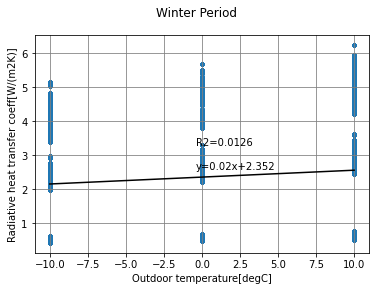

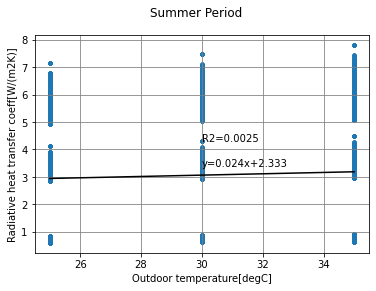

In [10]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Outdoor temperature[degC]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "theta_e",
       y_data_name = "h_rv"
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Outdoor temperature[degC]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "theta_e",
       y_data_name = "h_rv"
      )

### 外気側表面に入射する日射量（j_surf）× 放射熱伝達率（h_rv）

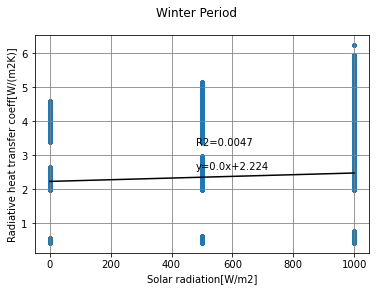

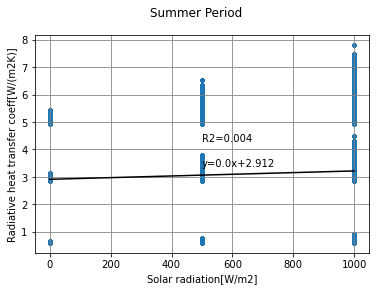

In [11]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Solar radiation[W/m2]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "j_surf",
       y_data_name = "h_rv"
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Solar radiation[W/m2]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "j_surf",
       y_data_name = "h_rv"
      )

### 外気側表面日射吸収率（a_surf）× 放射熱伝達率（h_rv）

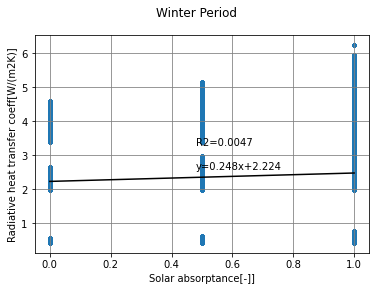

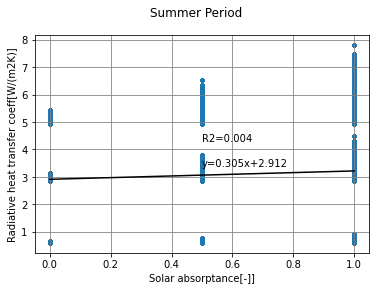

In [12]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Solar absorptance[-]]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "a_surf",
       y_data_name = "h_rv"
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Solar absorptance[-]]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "a_surf",
       y_data_name = "h_rv"
      )

### 外気側部材の熱コンダクタンス（C_1）× 放射熱伝達率（h_rv）

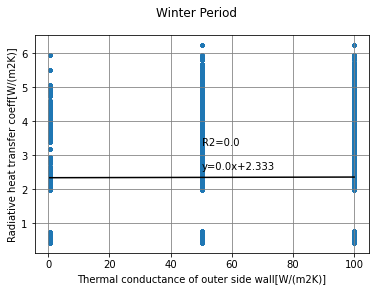

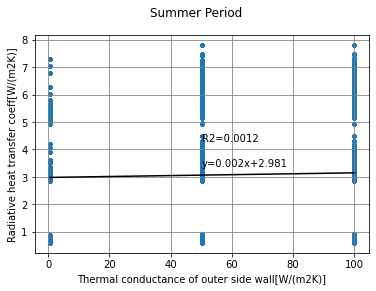

In [13]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Thermal conductance of outer side wall[W/(m2K)]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "C_1",
       y_data_name = "h_rv"
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Thermal conductance of outer side wall[W/(m2K)]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "C_1",
       y_data_name = "h_rv"
      )

### 室内側部材の熱コンダクタンス（C_2）× 放射熱伝達率（h_rv）

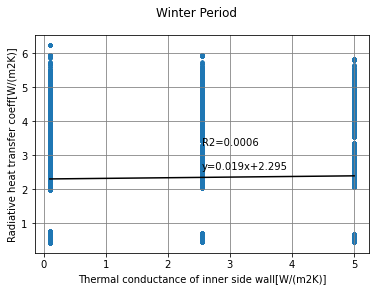

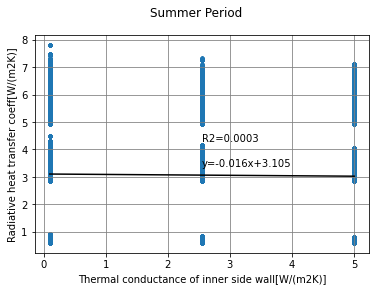

In [14]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Thermal conductance of inner side wall[W/(m2K)]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "C_2",
       y_data_name = "h_rv"
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Thermal conductance of inner side wall[W/(m2K)]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "C_2",
       y_data_name = "h_rv"
      )

### 通気層の長さ（l_h）× 放射熱伝達率（h_rv）

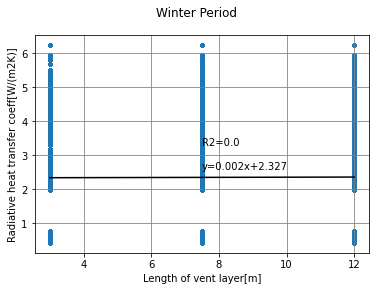

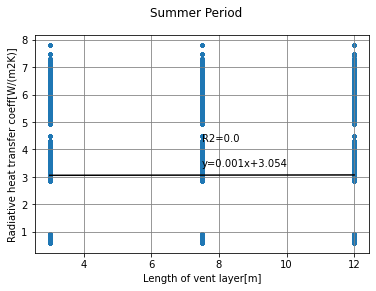

In [15]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Length of vent layer[m]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "l_h",
       y_data_name = "h_rv"
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Length of vent layer[m]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "l_h",
       y_data_name = "h_rv"
      )

### 通気層の厚さ（l_d）× 放射熱伝達率（h_rv）

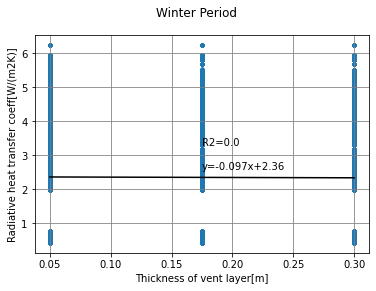

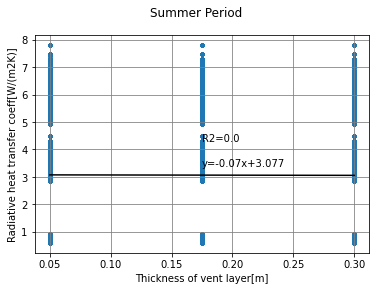

In [16]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Thickness of vent layer[m]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "l_d",
       y_data_name = "h_rv"
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Thickness of vent layer[m]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "l_d",
       y_data_name = "h_rv"
      )

### 通気層の傾斜角（angle）× 放射熱伝達率（h_rv）

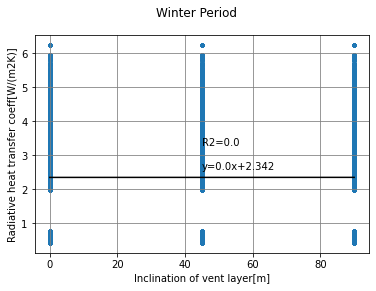

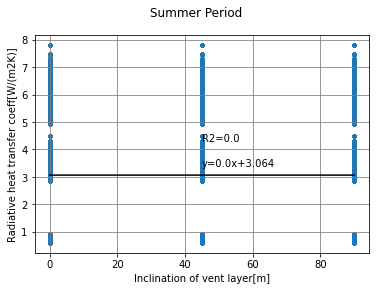

In [17]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Inclination of vent layer[m]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "angle",
       y_data_name = "h_rv"
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Inclination of vent layer[m]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "angle",
       y_data_name = "h_rv"
      )

### 通気層の平均風速（v_a）× 放射熱伝達率（h_rv）

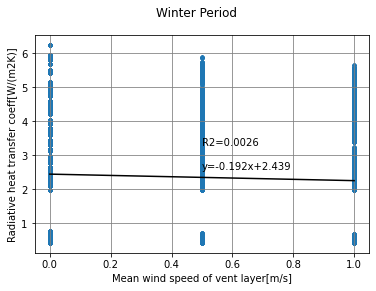

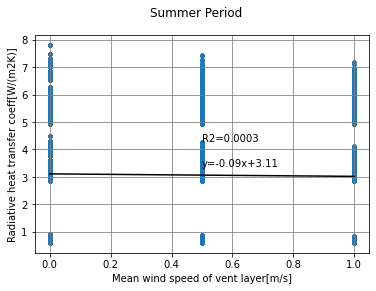

In [18]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Mean wind speed of vent layer[m/s]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "v_a",
       y_data_name = "h_rv"
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Mean wind speed of vent layer[m/s]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "v_a",
       y_data_name = "h_rv"
      )

### 通気層に面する面2の放射率（emissivity_2）× 放射熱伝達率（h_rv）

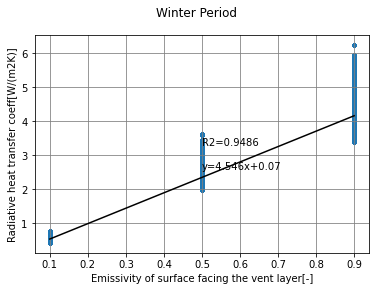

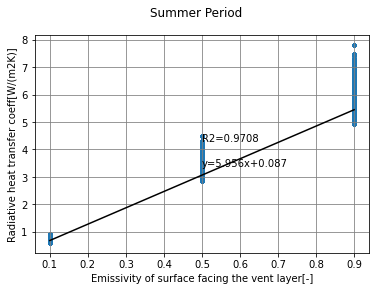

In [19]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Emissivity of surface facing the vent layer[-]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "emissivity_2",
       y_data_name = "h_rv"
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Emissivity of surface facing the vent layer[-]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "emissivity_2",
       y_data_name = "h_rv"
      )

## 放射熱伝達率の推定
### 冬期と夏期の差がほとんどないので、データを統合する

In [20]:
df_target = pd.concat([df_winter, df_summer])
df_target

,theta_e,theta_r,j_surf,a_surf,C_1,C_2,l_h,l_w,l_d,angle,...,theta_as_e,k_e,q_room_side,heat_balance_0,heat_balance_1,heat_balance_2,heat_balance_3,heat_balance_4,delta_theta_as_e-theta_r,delta_theta_sat-theta_r
0,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-4.538192,0.817940,-2.315751,2.842171e-14,2.886580e-15,-1.776357e-15,-2.842171e-14,-2.220446e-16,-24.538192,-30.0
1,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-4.941901,0.831397,-2.401513,0.000000e+00,7.105427e-15,-7.105427e-15,5.684342e-14,-8.881784e-16,-24.941901,-30.0
2,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-4.989114,0.832970,-2.426156,2.842171e-14,0.000000e+00,-3.552714e-15,2.842171e-14,4.440892e-16,-24.989114,-30.0
3,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-9.856252,0.995208,-2.898810,2.842171e-14,8.881784e-15,0.000000e+00,0.000000e+00,0.000000e+00,-29.856252,-30.0
4,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-9.814749,0.993825,-2.907471,-2.842171e-14,-3.552714e-15,-7.105427e-15,0.000000e+00,-8.881784e-16,-29.814749,-30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708583,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,50.470072,0.488960,56.476449,0.000000e+00,-4.547474e-13,-1.136868e-13,8.526513e-14,0.000000e+00,23.470072,48.0
708584,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,53.646967,0.555145,67.754820,-1.818989e-12,-2.842171e-13,-2.273737e-13,2.842171e-14,0.000000e+00,26.646967,48.0
708585,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,40.829960,0.288124,32.700991,-9.094947e-13,4.227729e-13,5.684342e-14,-2.842171e-14,-3.552714e-15,13.829960,48.0
708586,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,46.506060,0.406376,49.057263,-9.094947e-13,1.023182e-12,2.273737e-13,-8.526513e-14,7.105427e-15,19.506060,48.0


### 最小二乗法による回帰モデルを作成

In [21]:
formula_2 = "h_rv ~ emissivity_2"
model_1 = ols(formula_2, df_target).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   h_rv   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                 3.345e+06
Date:                Sun, 27 Dec 2020   Prob (F-statistic):               0.00
Time:                        18:16:48   Log-Likelihood:            -2.7271e+05
No. Observations:              334611   AIC:                         5.454e+05
Df Residuals:                  334609   BIC:                         5.454e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0789      0.002     45.672      0.000       0.076       0.082
emissivity_2     5.2921      0.003   1828.929      0.000       5.286       5.298
==============================================================================
Omnibus:                    21852.534   Durbin-Watson:                   0.904
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            74311.939
Skew:                           0.286   Prob(JB):                         0.00
Kurtosis:                       5.237   Cond. No.                         3.90
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 推定値の精度を確認

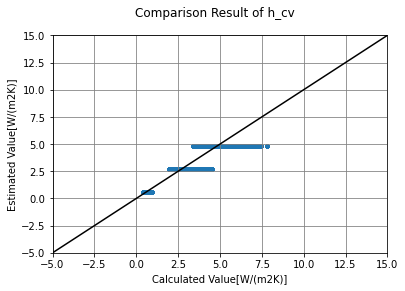

In [22]:
setPltComparison(df = df_target,
       fig_title = "Estimation Result of Radiative heat transfer coeff",
       x_label = "Calculated Value[W/(m2K)]",
       y_label = "Estimated Value[W/(m2K)]", 
       x_data_name = "h_rv",
       y_data = model_1.predict()
      )

## 放射熱伝達率の感度解析

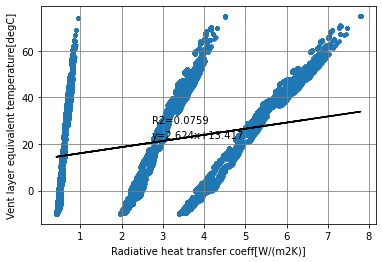

In [23]:
setPltSingle(df = df_target,
       fig_title = "",
       x_label = "Radiative heat transfer coeff[W/(m2K)]",
       y_label = "Vent layer equivalent temperature[degC]", 
       x_data_name = "h_rv",
       y_data_name = "theta_as_e"
      )

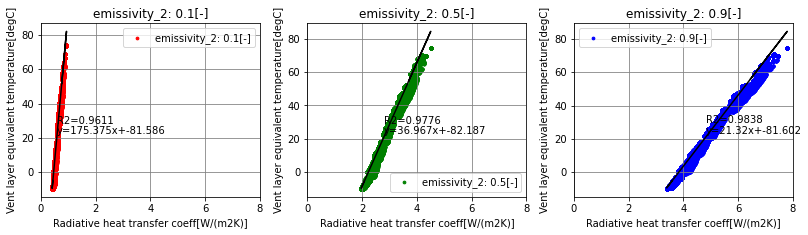

In [24]:
setPltThreeCols(df = df_target,
       fig_title = "",
       x_label = "Radiative heat transfer coeff[W/(m2K)]",
       y_label = "Vent layer equivalent temperature[degC]", 
       x_data_name = "h_rv",
       y_data_name = "theta_as_e",
       condition_data_name = "emissivity_2",
       unit_label = "-",
       conditions = np.array([0.1, 0.5, 0.9])
      )

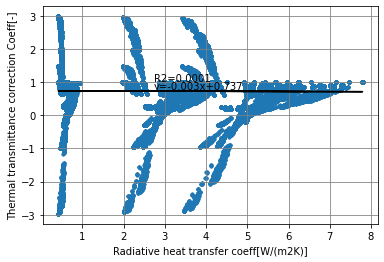

In [25]:
setPltSingle(df = df_target,
       fig_title = "",
       x_label = "Radiative heat transfer coeff[W/(m2K)]",
       y_label = "Thermal transmittance correction Coeff[-]", 
       x_data_name = "h_rv",
       y_data_name = "k_e"
      )

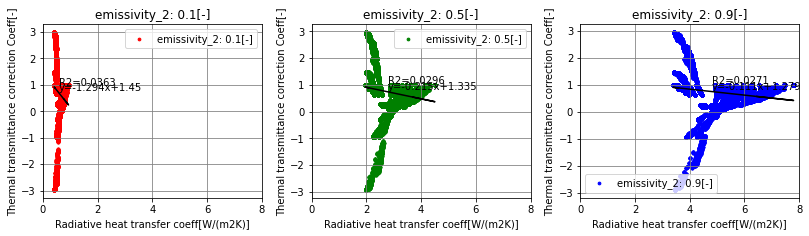

In [26]:
setPltThreeCols(df = df_target,
       fig_title = "",
       x_label = "Radiative heat transfer coeff[W/(m2K)]",
       y_label = "Thermal transmittance correction Coeff[-]", 
       x_data_name = "h_rv",
       y_data_name = "k_e",
       condition_data_name = "emissivity_2",
       unit_label = "-",
       conditions = np.array([0.1, 0.5, 0.9])
      )